# FALL 2020 -> CSE 5334 -> Data Minning
## Assignment 3
### Name:  Tirumala Manukonda (UTA ID# 1001662386)

#### The goal of this assignment is to learn about the Naive Bayes Classifier (NBC).  

__Summary__:
- Generate training and test data using IMDB Large Movie dataset
- Build the vocabulary list of the training data and removing the words that has frequency less than 5
- Calculate the probalities 
  - Find the P[“the”] =  num of documents containing ‘the’ / num of all documents
  - Conditional probability based on the sentiment, P[“the” | Positive]  = # of positive documents containing “the” / num of all positive review documents
- Calculate accuracy using five fold cross validation
- Compare the effect of Smoothing
- Derive Top 10 words that predicts positive and negative class
- Using the test dataset, Calculate final accuracy using optimal parameter from smoothing and then do 5 fold cross validation 

In [352]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
tf.gfile = tf.io.gfile
import re
import collections
from collections import Counter, defaultdict
import math
from sklearn.metrics import accuracy_score

- Import the libraries for the model implemention

In [353]:
def load_directory_data(directory):
    data = {}
    data["review"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["review"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

- The dataset in the given directory is read and creates a dataframe using tensor flow

In [354]:
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

- Merging positive and negative examples, and dding a polarity column and then shuffle the dataframe

In [355]:
def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)
  
    train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
    return train_df, test_df

- Links the dataset and loading into train and test data sets, Preferred this way of splitting data
  and Training dataset  is used intially for spliting and doing 5 fold cross validations, Final accuracy is found using testing   dataset

In [356]:
train, test = download_and_load_datasets()

In [357]:
train.head()

,review,sentiment,polarity
0,Another entertaining Travolta dance flick! GRE...,8,1
1,"The second official episode of the ""Columbo"" s...",8,1
2,I have seen romantic comedies and this is one ...,4,0
3,What do I say about such an absolutely beautif...,10,1
4,I really liked this movie despite one scene th...,7,1


- Top 5 rows of the dataframe to get idea of how the data is

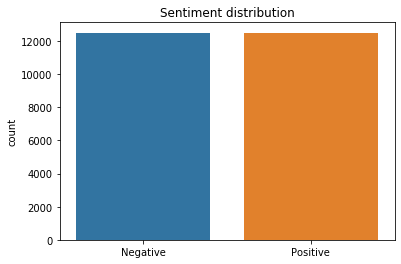

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt
f = sns.countplot(x='polarity', data=train)
f.set_title("Sentiment distribution")
f.set_xticklabels(['Negative', 'Positive'])
plt.xlabel("");

- Observing the positive and negative labels in the class and they are equally distributed

In [359]:
X = train['review'].values
y = train['polarity'].values

- Putting all the revies as the input data and Y as the output lables to predict

In [360]:
def split_sentence(sentence):
    return (x.lower() for x in re.split('\W+', sentence.strip()) if x)

- To split the sentences into words or tokens

In [361]:
def generate_vocabulary(train_captions):
    word_count = collections.Counter()

    for current_sentence in train_captions:
        word_count.update(split_sentence(str(current_sentence)))

    return {key:value for (key, value) in word_count.items() if value > 5}

- This is check the counts or frequency of all the words in the review and then it removes all the words that are having less     than 5

In [362]:
vocabulary_list = generate_vocabulary(train['review'])
print(vocabulary_list)
dir(vocabulary_list)

{'another': 4330, 'entertaining': 1443, 'travolta': 43, 'dance': 744, 'flick': 1258, 'great': 9060, 'music': 3057, 'mood': 432, 'and': 164140, 'scenes': 5213, 'debra': 52, 'winger': 28, 'is': 107332, 'beautiful': 2178, 'like': 20281, 'saturday': 220, 'night': 2162, 'fever': 116, 'this': 76007, 'macho': 71, 'film': 40159, 'features': 643, 'extremely': 1068, 'improbable': 59, 'of': 145864, 'women': 1819, 'falling': 383, 'for': 44345, 'almost': 3140, 'begging': 55, 'him': 8879, 'to': 135724, 'have': 27731, 'sex': 1685, 'with': 44130, 'them': 7972, 'the': 336749, 'second': 1962, 'official': 106, 'episode': 1659, 'columbo': 206, 'series': 3417, 'murder': 1063, 'by': 22548, 'book': 2421, 'filmed': 765, 'later': 2200, 'hit': 1088, 'airwaves': 11, 'first': 9064, 'robert': 951, 'culp': 27, 'who': 21441, 'would': 12436, 'match': 594, 'wits': 34, 'peter': 770, 'falk': 122, 's': 63602, 'detective': 460, 'in': 93976, 'several': 1420, 'future': 900, 'installments': 20, 'terrific': 433, 'as': 46935, 

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [363]:
proba_the = len(train[train['review'].str.contains("the")]) / len(train)
proba_the

0.99376

- proba_the to get probability of the word'the' in the Training review document,its based on  num of documents containing ‘the’   / num of all documents

In [364]:
pos_count = train[train.polarity.eq(1)]
proba_cond = len(pos_count[pos_count['review'].str.contains("the")]) / len(pos_count)
proba_cond

0.9932

- proba_cond to get the conditional probability of the word 'the' wrt to the positive reviews ,i.e no of positive documents containing “the” / num of all positive review documents

In [365]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords

class Tokenizer:
    
    def clean(self, text):
        no_html = BeautifulSoup(text).get_text()
        clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
        return re.sub("(\s+)", " ", clean)
    def tokenize(self, text):
        clean = self.clean(text).lower()
        stopwords_en = stopwords.words("english")
        return [w for w in re.split("\W+", clean) if not w in stopwords_en]

- Tokenizer class to create word document list

In [366]:
class NB:
  
    def __init__(self, classes, tokenizer, kSmooth):
        self.tokenizer = tokenizer
        self.classes = classes #label classes
        self.kSmooth = kSmooth #smoothing param
        
   # creates the lists data[0] and data[1] label   
    def group_by_class(self, X, y):
        data = dict()
        for c in self.classes:
        
            data[c] = X[np.where(y == c)]
        return data
     #fit the training the data and calculates the log_class_priors, log probability for each class      
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
            self.n_class_items[c] = len(data)
            self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
            self.word_counts[c] = defaultdict(lambda: 0)
          
            for text in data:
                counts = Counter(self.tokenizer.tokenize(text))
                for word, count in counts.items():
                    if word not in self.vocab:
                        self.vocab.add(word)

                    self.word_counts[c][word] += count
                
        return self
     
        # ksmooth : the smoothing parameter, returns the loglikelyhod prob
    def smoothing(self, word, text_class):
        num = self.word_counts[text_class][word] + self.kSmooth
        denom = self.n_class_items[text_class] + (len(self.vocab)* self.kSmooth)
        return math.log(num / denom)
    
      #predicts the y class, by computing  posterior log probability of X
    def predict(self, X):
        result = []
        for text in X:
          
            class_scores = {c: self.log_class_priors[c] for c in self.classes}

            words = set(self.tokenizer.tokenize(text))
            for word in words:
                if word not in self.vocab: continue

                for c in self.classes:
                
                    log_w_given_c = self.smoothing(word, c)
                    class_scores[c] += log_w_given_c
                
            result.append(max(class_scores, key=class_scores.get))

        return result
    
    

- The navies bayes model, which takes the word list and it calculates the posterior probabilities, using the prior probabilities and the condtional hypothensis

In [367]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 99)

- Divide the train dataset into X_train and X_test, train the model on X_train and predicts the accuracy on the X_test, which is    Development data for my model 

In [368]:
#Accuracy on the development dataset with laplace smoothing 
nb = NB(classes=np.unique(y),  tokenizer=Tokenizer(),kSmooth= 1)
nb = nb.fit(X_train, y_train)
y_hat = nb.predict(X_test)
accuracy_score(y_test, y_hat)

0.8564

- 85.64% of accuracy on the development dataset

In [369]:
#5 fold cross validation

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)

scores =[]
for train_index, test_index in skf.split(X,y): 
    print("Train:", train_index, "Development:", test_index) 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    nb = nb.fit(X_train, y_train)
    y_hat = nb.predict(X_test)
    scores.append(accuracy_score(y_test, y_hat))
print(scores)
print(np.mean(scores))

Train: [ 4962  4966  4969 ... 24997 24998 24999] Development: [   0    1    2 ... 5016 5018 5020]
Train: [    0     1     2 ... 24997 24998 24999] Development: [ 4962  4966  4969 ... 10009 10010 10012]
Train: [    0     1     2 ... 24997 24998 24999] Development: [ 9972  9976  9977 ... 15043 15044 15046]
Train: [    0     1     2 ... 24997 24998 24999] Development: [14951 14957 14959 ... 19998 20002 20003]
Train: [    0     1     2 ... 19998 20002 20003] Development: [19997 19999 20000 ... 24997 24998 24999]
[0.8558, 0.8544, 0.8564, 0.8604, 0.8672]
0.85884


- 5 StratifiedKFold cross validation and its the accuracy scores of [0.8558, 0.8544, 0.8564, 0.8604, 0.8672] and the mean accuracy as 85.88%

In [370]:
# Smoothing with the aplha values of ksmooth
ksmooth =[1,0.1,0.001,0.0001,0.00001]
Smoothingscores=[]
for i in ksmooth: 
    nb = NB(classes=np.unique(y),  tokenizer=Tokenizer(),kSmooth= i)
    nb = nb.fit(X_train, y_train)
    y_hat = nb.predict(X_test)
    Smoothingscores.append(accuracy_score(y_test, y_hat))
print(Smoothingscores)

[0.8672, 0.8628, 0.8392, 0.826, 0.8164]


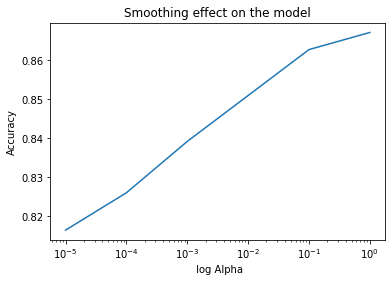

In [371]:
# comparision of smoothing with accuracy
plt.plot((ksmooth),Smoothingscores)
plt.xscale("log")
plt.xlabel(" log Alpha")
plt.ylabel("Accuracy")
plt.title("Smoothing effect on the model")
plt.show()

__Analysis__ :- As we see above, the performance of the model is good when the smoothing parameter value is 1 (laplace Smoothing) and its slowly decreases w.r.t log aplha values decreases.

In [372]:
X = test['review'].values
y = test['polarity'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 99)

In [373]:
#Accuracy on the development dataset with laplace smoothing 
nb = NB(classes=np.unique(y),  tokenizer=Tokenizer(),kSmooth= 1)
nb = nb.fit(X_train, y_train)
y_hat = nb.predict(X_test)
accuracy_score(y_test, y_hat)

0.8665333333333334

__Analysis__ :- Using the optimal parameter, ksmooth=1 that is obtained from the development set validation, 
                 we got the final accuracy of Test data set as 86.65%

In [374]:
#5 fold cross validation

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=None)

scores =[]
for train_index, test_index in skf.split(X,y): 
    print("Train:", train_index, "Test:", test_index) 
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    nb = nb.fit(X_train, y_train)
    y_hat = nb.predict(X_test)
    scores.append(accuracy_score(y_test, y_hat))
print(scores)
print(np.mean(scores))

Train: [ 4966  4967  4968 ... 24997 24998 24999] Test: [   0    1    2 ... 5055 5056 5058]
Train: [    0     1     2 ... 24997 24998 24999] Test: [ 4966  4967  4968 ... 10093 10099 10102]
Train: [    0     1     2 ... 24997 24998 24999] Test: [ 9927  9928  9930 ... 15015 15016 15017]
Train: [    0     1     2 ... 24997 24998 24999] Test: [14970 14971 14973 ... 20010 20012 20013]
Train: [    0     1     2 ... 20010 20012 20013] Test: [19984 19986 19987 ... 24997 24998 24999]
[0.8652, 0.8724, 0.8742, 0.8756, 0.8718]
0.8718400000000001


- With the 5 fold cross validations, these are the values of accuracy scores [0.8652, 0.8724, 0.8742, 0.8756, 0.8718] and a mean accuracy of 87.18%